In [67]:
# The path can also be read from a config file, etc.
OPENSLIDE_PATH = r'C:\Users\johng\Downloads\openslide-win64-20231011\bin'

import os
if hasattr(os, 'add_dll_directory'):
    # Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide

In [68]:
import os
import sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt 
import PIL
import openslide
import skimage.io
from tqdm.notebook import tqdm
import zipfile
import cv2 as cv
import torch
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import copy
from PIL import Image
import glob
import random
import torch
from torchvision import transforms
import re
from sklearn.metrics import roc_curve, roc_auc_score, ConfusionMatrixDisplay

In [50]:
def sample_tile_images(N_cancer, N_noncancer, path):
    cancer_imgs = glob.glob(os.path.join(path, '*_cancer.png')) # select all file paths of images containing cancer
    noncancer_imgs = glob.glob(os.path.join(path, '*_noncancer.png')) # same for images not containing any cancer
    tiles = random.sample(cancer_imgs, N_cancer) + random.sample(noncancer_imgs, N_noncancer) # sample N_cancer and N_noncancer file paths from the two lists above
    labels = np.concatenate((np.ones(N_cancer), np.zeros(N_noncancer))) # label as 1 for cancer and 0 for non-cancer
    indices = list(range(N_cancer + N_noncancer)) 
    random.shuffle(indices) # random list of indices to shuffle the list containing cancer and non-cancer file paths
    return [tiles[i] for i in indices], labels[indices]

cancer


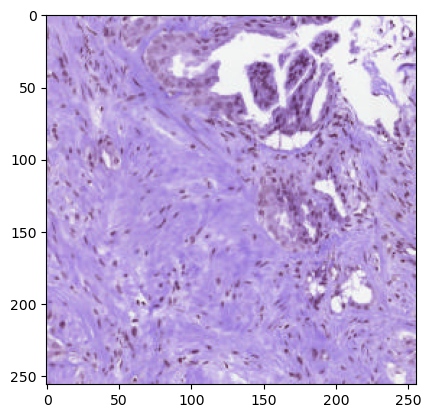

In [51]:
path = "data/tiled_images/output/" # path to the folder containing the imgs

cancer_imgs = glob.glob(os.path.join(path, '*_cancer.png')) # select all file paths of images containing cancer
noncancer_imgs = glob.glob(os.path.join(path, '*_noncancer.png')) # same for images not containing any cancer
# len(cancer_imgs)
# len(noncancer_imgs)

N_cancer = 100 # number of imgs with cancer
N_noncancer = 100 # number of imgs without cancer

# Display some random images to observe the features of cancer vs non-cancer cells
tiles, labels = sample_tile_images(N_cancer, N_noncancer, path) # get list of train images
label_dict = {1: 'cancer', 0: 'non-cancer'} # dictionary of labels
# j = random.randint(0, len(labels)) # pick a random image
j = 0 # pick a random image
im_frame = Image.open(tiles[j])
np_frame = np.array(im_frame)
plt.imshow(np_frame)
print(label_dict[labels[j]])

In [52]:
def train_model(net, dataloader, criterion, optimizer, epochs=5):
    i = 0
    run_loss = 0
    # print start
    print('Start of training')
    for epoch in range(epochs):
        print('Epoch:', epoch)
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            run_loss += loss.item()
        # print statistics
        print('Loss:', run_loss, '\n')
        run_loss = 0.0
        
    return net

pxsize = 227 # size of the images to be used by the network, can be center-cropped below 256

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(pxsize),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [53]:
# Split and prepare data for training
train_fraction = 0.7 # fraction of train samples
pxsize = 227 # size of the images to be used by the network, can be center-cropped below 256
random.seed(123)

tiles, labels = sample_tile_images(N_cancer, N_noncancer, path) # get list of train images
data = preprocess(Image.open(tiles[0]).convert('RGB')).reshape(1,3,pxsize,pxsize) # convert to RGB to drop alpha (transparency) channel of png 

for tile in tiles[1:]:
    data = torch.cat((preprocess(Image.open(tile).convert('RGB')).reshape(1,3,pxsize,pxsize), data), axis=0)

X_train, X_validation = torch.split(data, int(train_fraction*len(data)))
y_train, y_validation = torch.split(torch.Tensor(labels).type(torch.LongTensor), int(train_fraction*len(labels)))

In [54]:
torch.manual_seed(123)

# Define hyperparamerts of the network and train it
batch_size = 32
train_dataset = TensorDataset(X_train, y_train) 
dataloader = DataLoader(train_dataset, batch_size = batch_size)
res50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    
res50.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2),
               nn.Softmax())

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(res50.fc.parameters(), lr=0.0001)
res50.to('cuda')
epochs = 3

run_loss = 0
# print start
print('Start of training')
for epoch in range(epochs):
    print('Epoch:', epoch)
    for inputs, labels in dataloader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        outputs = res50.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        run_loss += loss.item()
    # print statistics
    print('Loss:', run_loss, '\n')
    run_loss = 0.0

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [8]:
from sklearn.metrics import confusion_matrix

res50.to('cpu')
pred_labels = torch.argmax(res50(X_validation), axis=1)
print("Predicted labels")
print(pred_labels)
print("True labels")
print(y_validation)

cm = confusion_matrix(pred_labels, y_validation)
print("Confusion Matrix")
print(cm)
print("Accuracy: ", (sum(pred_labels==y_validation)/len(pred_labels)).item())

C:\Users\johng\anaconda3\Lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Predicted labels
tensor([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0])
True labels
tensor([1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0])
Confusion Matrix
[[23 22]
 [ 7  8]]
Accuracy:  0.5166666507720947


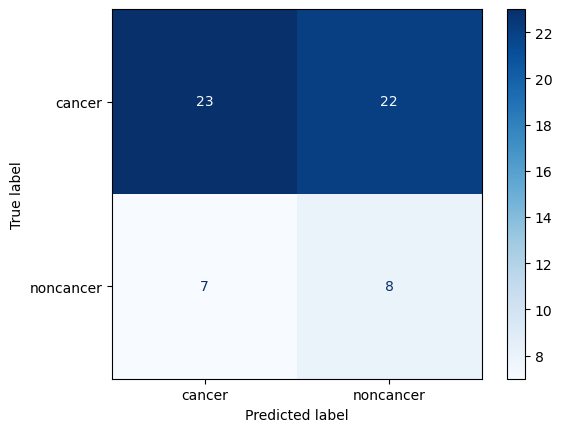

In [29]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(pred_labels, y_validation),
                              display_labels= ['cancer', 'noncancer'])


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp = disp.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal')

plt.show()

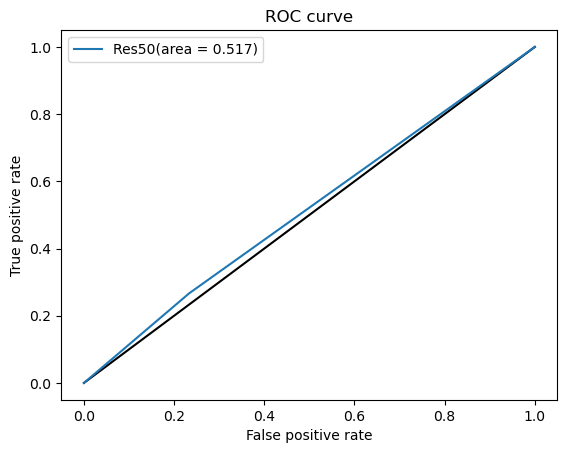

In [69]:
# https://discuss.pytorch.org/t/how-to-plot-roc-curve-using-pytorch-model/122033/3
fpr, tpr, _ = roc_curve(y_validation, pred_labels)
roc_auc = roc_auc_score(y_validation, pred_labels)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k-')
plt.plot(fpr, tpr, label='Res50(area = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [30]:
models_dir = 'models/'

if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
path = os.path.join(models_dir, 'res50.pth')
torch.save(res50, path)

In [92]:
# PRIOR INPUTS
# Location of the files
data_dir = 'data/train_images'
mask_dir = 'data/train_label_masks/'
out_dir = 'data/tiled_images/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
# Location of training labels
samples = pd.read_csv('train.csv')

# Creates a numpy array from a selected tile in a slide
def tile_array(slide, tile, tile_size, level):
    region = np.copy(np.asarray(slide.read_region((tile['xloc']*(4**level),tile['yloc']*(4**level)), level, (tile_size,tile_size)))) # The position is wrt. level 0, so must convert to level 0 coordinates by multiplying by the downsampling factor.
    if tile['required_padding']:
        region[region==0] = 255     
    return region

def get_tile_locations_from_slide(slide, tile_size, N, level):
    tiles = []
    required_padding = False
    xlocs, ylocs = np.arange(0, slide.level_dimensions[level][0], tile_size), np.arange(0, slide.level_dimensions[level][1], tile_size) # Get the coordinates of the top left corners of the tiles.
    for x_i, xloc in enumerate(xlocs):
        for y_i, yloc in enumerate(ylocs):
            region = np.copy(slide.read_region((xloc*(4**level),yloc*(4**level)), level, (tile_size,tile_size))) # The position is wrt. level 0, so must convert to level 0 coordinates by multiplying by the downsampling factor.
            region_arr = np.asarray(region)[:,:,:3] # Ignore the alpha channel
            if xloc+tile_size > slide.level_dimensions[level][0] or yloc+tile_size > slide.level_dimensions[level][1]: # if the tile goes out of bounds
                region_arr[region_arr==0] = 255
                required_padding = True
            pixel_sum = region_arr.sum()
            tiles.append({'xloc': xloc, 'yloc': yloc, 'pixel_sum': pixel_sum, 'required_padding': required_padding}) # store top left corner location and the tile's pixel_sum
            required_padding = False
    sorted_tiles = sorted(tiles, key= lambda d: d['pixel_sum']) # Sort tiles based on their pixel_sum field
    sorted_tiles = sorted_tiles[:N] # Get top N tiles
    return sorted_tiles

# Returns if a region of the mask slide contains cancerous tissue or not
def classify_as_cancerous(region, provider):
    if provider == 'karolinska':
        if 2 in region:
            return 'cancer'
        else:
            return 'noncancer'
    elif provider == 'radboud':
        if 3 in region or 4 in region or 5 in region:
            return 'cancer'
        else:
            return 'noncancer'
    else:
        raise Exception("Provider must be either karolinska or radboud")
        
def save_img(img, filename, folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
    print(f'Saving to: {os.path.join(folder, filename+".png")}')
    cv.imwrite(os.path.join(folder, filename+".png"), img)

In [95]:
def make_tiles_from_image(indx, tile_size, level, output_folder=None):
    sample = samples.iloc[int(indx)]
    image_id = sample.loc['image_id']
    data_provider = sample.loc['data_provider']
    slide = openslide.OpenSlide(os.path.join(data_dir, image_id+'.tiff'))
    mask = openslide.OpenSlide(os.path.join(mask_dir, image_id+'_mask.tiff'))
    tiles = get_tile_locations_from_slide(slide, tile_size=256, N=36, level=1)
    
    if output_folder == None:
        output_folder = 'data/tiled_images/tiles/' + image_id
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        
    for tile in tiles:
        tile_coordinate = f'''({str(tile['xloc'])}, {str(tile['yloc'])})'''
        image_tile_array = tile_array(slide, tile, tile_size, level)
        mask_tile_array = tile_array(mask, tile, tile_size, level)
        label = classify_as_cancerous(mask_tile_array, data_provider)
        filename = f'{image_id}_{tile_coordinate}_{label}'
        save_img(image_tile_array, filename, output_folder)
    
    return os.path.join(data_dir, image_id+'.tiff'), output_folder



In [153]:
# Sample new slide, generate tiles and put them in a folder named as the original image
# Then, apply ResNet50 to each tile

# Load ResNet with weights trained previously
models_dir = 'models/'
res50 = torch.load(os.path.join(models_dir, 'res50.pth'))
res50.to('cpu')

# Choose the image that in which you want to overlap the cancer probability masks
indx = 200 # can choose any from 0 to 11000
tile_size = 256 # tile size
level = 1 # level
pxsize = 227
img_path, tiles_path = make_tiles_from_image(indx, tile_size, level, output_folder=None) # this will create a subfolder inside the specified output_folder containing the tiles 
tiles = glob.glob(os.path.join(tiles_path, '*cancer.png')) 
labels = [int('noncancer' not in tile) for tile in tiles]

X = preprocess(Image.open(tiles[0]).convert('RGB')).reshape(1,3,pxsize,pxsize) # convert to RGB to drop alpha channel of png 
for tile in tiles[1:]:
    X = torch.cat((preprocess(Image.open(tile).convert('RGB')).reshape(1,3,pxsize,pxsize), X), axis=0)

Y = torch.Tensor(labels).type(torch.LongTensor)
probs = nn.Softmax()(res50(X))[:,1].detach().numpy()
slide = openslide.OpenSlide(img_path)


Saving to: data/tiled_images/tiles/0550b23f29085f41b10d165a46ad4371\0550b23f29085f41b10d165a46ad4371_(2816, 256)_cancer.png
Saving to: data/tiled_images/tiles/0550b23f29085f41b10d165a46ad4371\0550b23f29085f41b10d165a46ad4371_(2560, 256)_cancer.png
Saving to: data/tiled_images/tiles/0550b23f29085f41b10d165a46ad4371\0550b23f29085f41b10d165a46ad4371_(1792, 256)_cancer.png
Saving to: data/tiled_images/tiles/0550b23f29085f41b10d165a46ad4371\0550b23f29085f41b10d165a46ad4371_(1536, 256)_cancer.png
Saving to: data/tiled_images/tiles/0550b23f29085f41b10d165a46ad4371\0550b23f29085f41b10d165a46ad4371_(3072, 256)_cancer.png
Saving to: data/tiled_images/tiles/0550b23f29085f41b10d165a46ad4371\0550b23f29085f41b10d165a46ad4371_(768, 256)_cancer.png
Saving to: data/tiled_images/tiles/0550b23f29085f41b10d165a46ad4371\0550b23f29085f41b10d165a46ad4371_(1024, 256)_cancer.png
Saving to: data/tiled_images/tiles/0550b23f29085f41b10d165a46ad4371\0550b23f29085f41b10d165a46ad4371_(256, 512)_cancer.png
Saving to:

C:\Users\johng\AppData\Local\Temp\ipykernel_12044\1086772166.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = nn.Softmax()(res50(X))[:,1].detach().numpy()


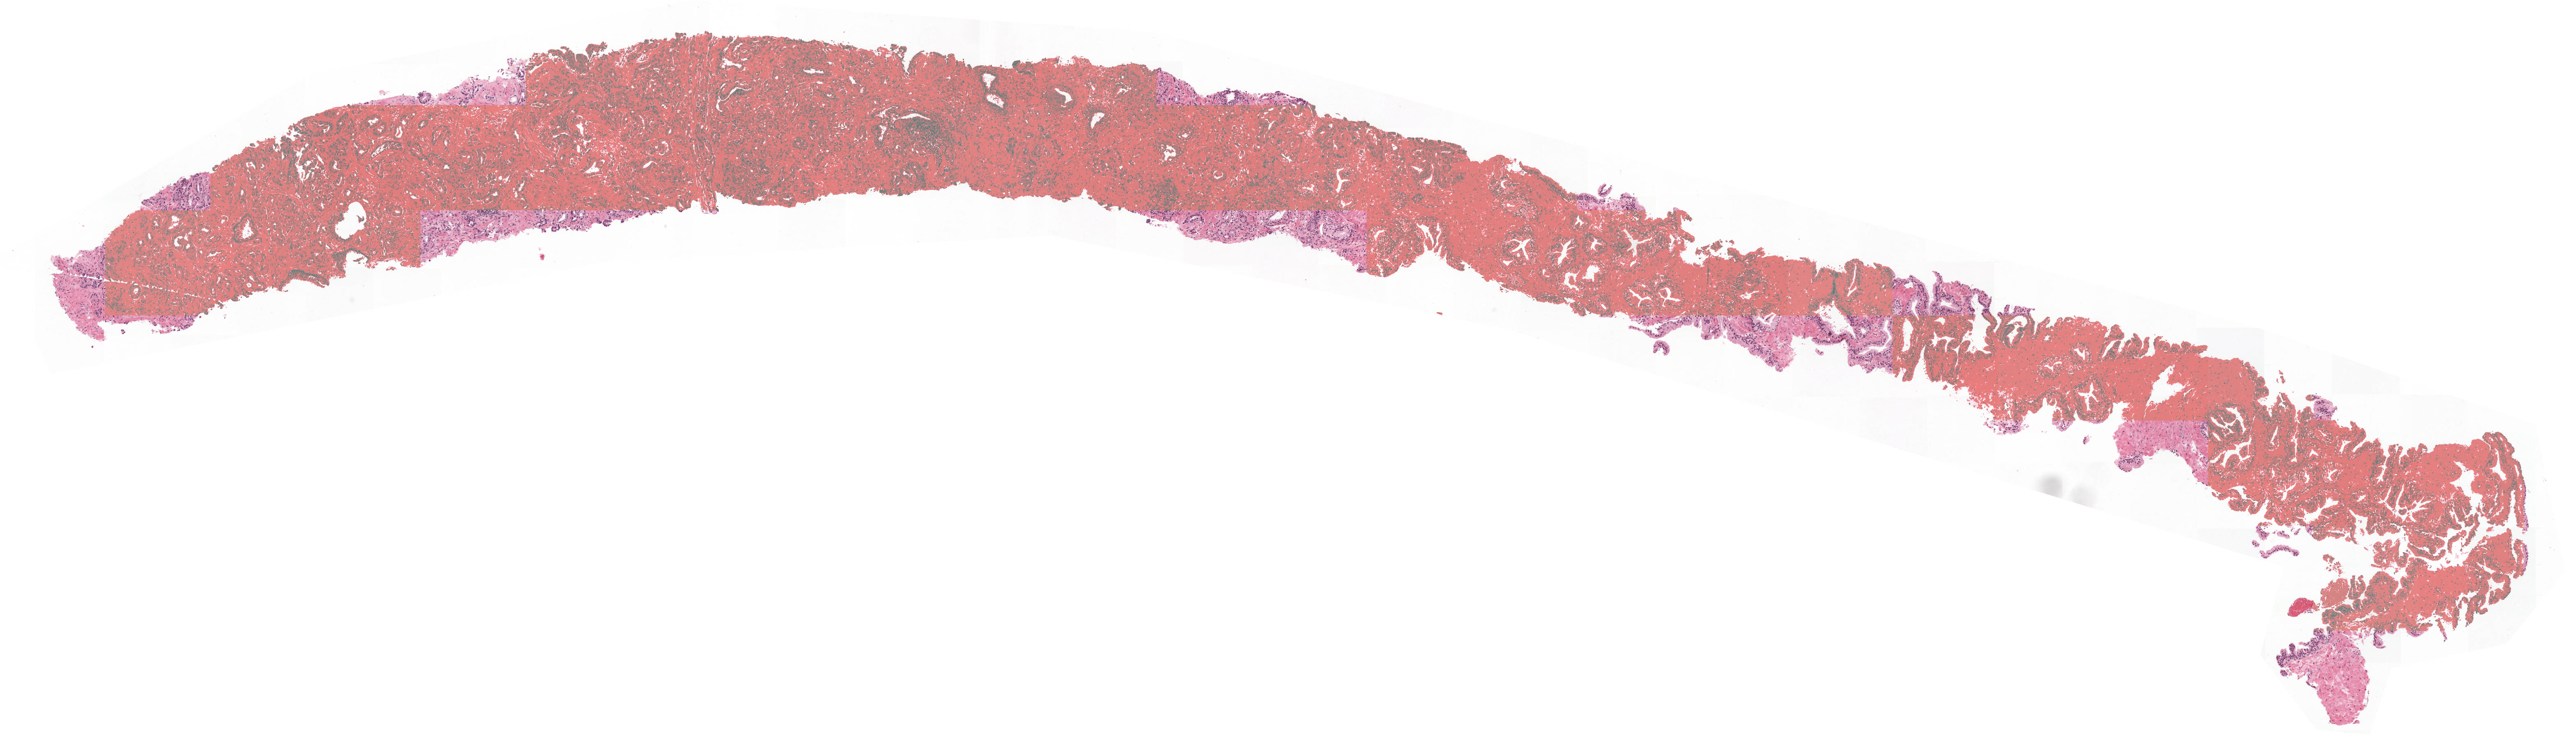

In [154]:
# Overlap red mask
content = np.asarray(slide.read_region((0,0), 1, slide.level_dimensions[1])).copy()

for i, tile in enumerate(tiles):
    x, y = [int(w) for w in re.findall(r'\d+', tile.split("_")[2])]
    detect_white = np.sum(content[y:(y+tile_size),x:(x+tile_size),:], axis=2) < 900
    if probs[i] > 0.4:
        content[y:(y+tile_size),x:(x+tile_size),1] = (1-detect_white)*content[y:(y+tile_size),x:(x+tile_size),1] + detect_white*(1-probs[i])*255
        content[y:(y+tile_size),x:(x+tile_size),2] = (1-detect_white)*content[y:(y+tile_size),x:(x+tile_size),2] + detect_white*(1-probs[i])*255
        # content[y:(y+tile_size),x:(x+tile_size),1] = (1-detect_white)*content[y:(y+tile_size),x:(x+tile_size),2] + detect_white*255
        # content[y:(y+tile_size),x:(x+tile_size),3] = (1-detect_white)*content[y:(y+tile_size),x:(x+tile_size),3] + detect_white*(0.99*255 + 0.0*probs[i]*255)

content_green = content.copy()
Image.fromarray(content)
